In [81]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as stats
import scipy.spatial as spatial

from spring_embedding_models import SequentialHierarchyCommunitySimple, SequentialHierarchyCommunityMulti
import utils
from springrank import SpringRank

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def load_labeled_network_and_get_largest_wcc(edge_file, node_file):
    # Step 1: Read node labels
    with open(node_file, 'r') as f:
        node_labels = set(line.strip().split(',')[0] for line in f if line.strip())

    # Step 2: Read edge list with labels directly
    G = nx.read_edgelist(edge_file, create_using=nx.DiGraph(), nodetype=str, delimiter=',')
    G = G.reverse(copy=True)

    # Step 3: Filter to only valid nodes from node list
    G = G.subgraph([n for n in G.nodes if n in node_labels]).copy()

    # Step 4: Get largest weakly connected component
    components = list(nx.weakly_connected_components(G))
    largest_wcc = max(components, key=len)
    G_wcc = G.subgraph(largest_wcc).copy()

    return G_wcc

In [3]:
G_wcc = load_labeled_network_and_get_largest_wcc('data/1998_fall_edge_list.csv', 'data/1998_fall_node_list.csv')
node_list = list(G_wcc.nodes)
A_wcc = nx.to_numpy_array(G_wcc, nodelist=node_list)

100%|██████████| 300/300 [01:59<00:00,  2.50it/s]


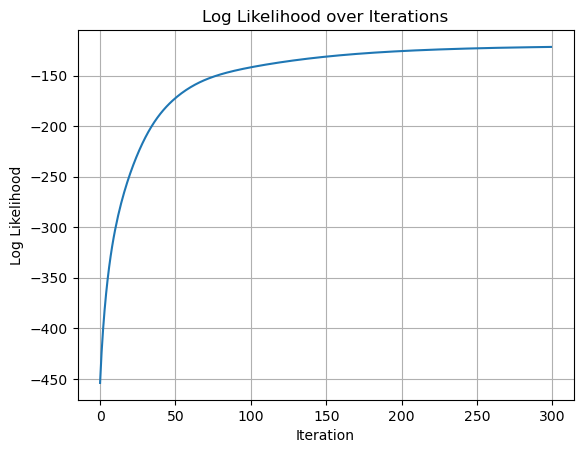

In [11]:
simple_model = SequentialHierarchyCommunitySimple(adj_matrix=A_wcc, embedding_dim=4, k=5, beta=1)
_ = simple_model.fit()

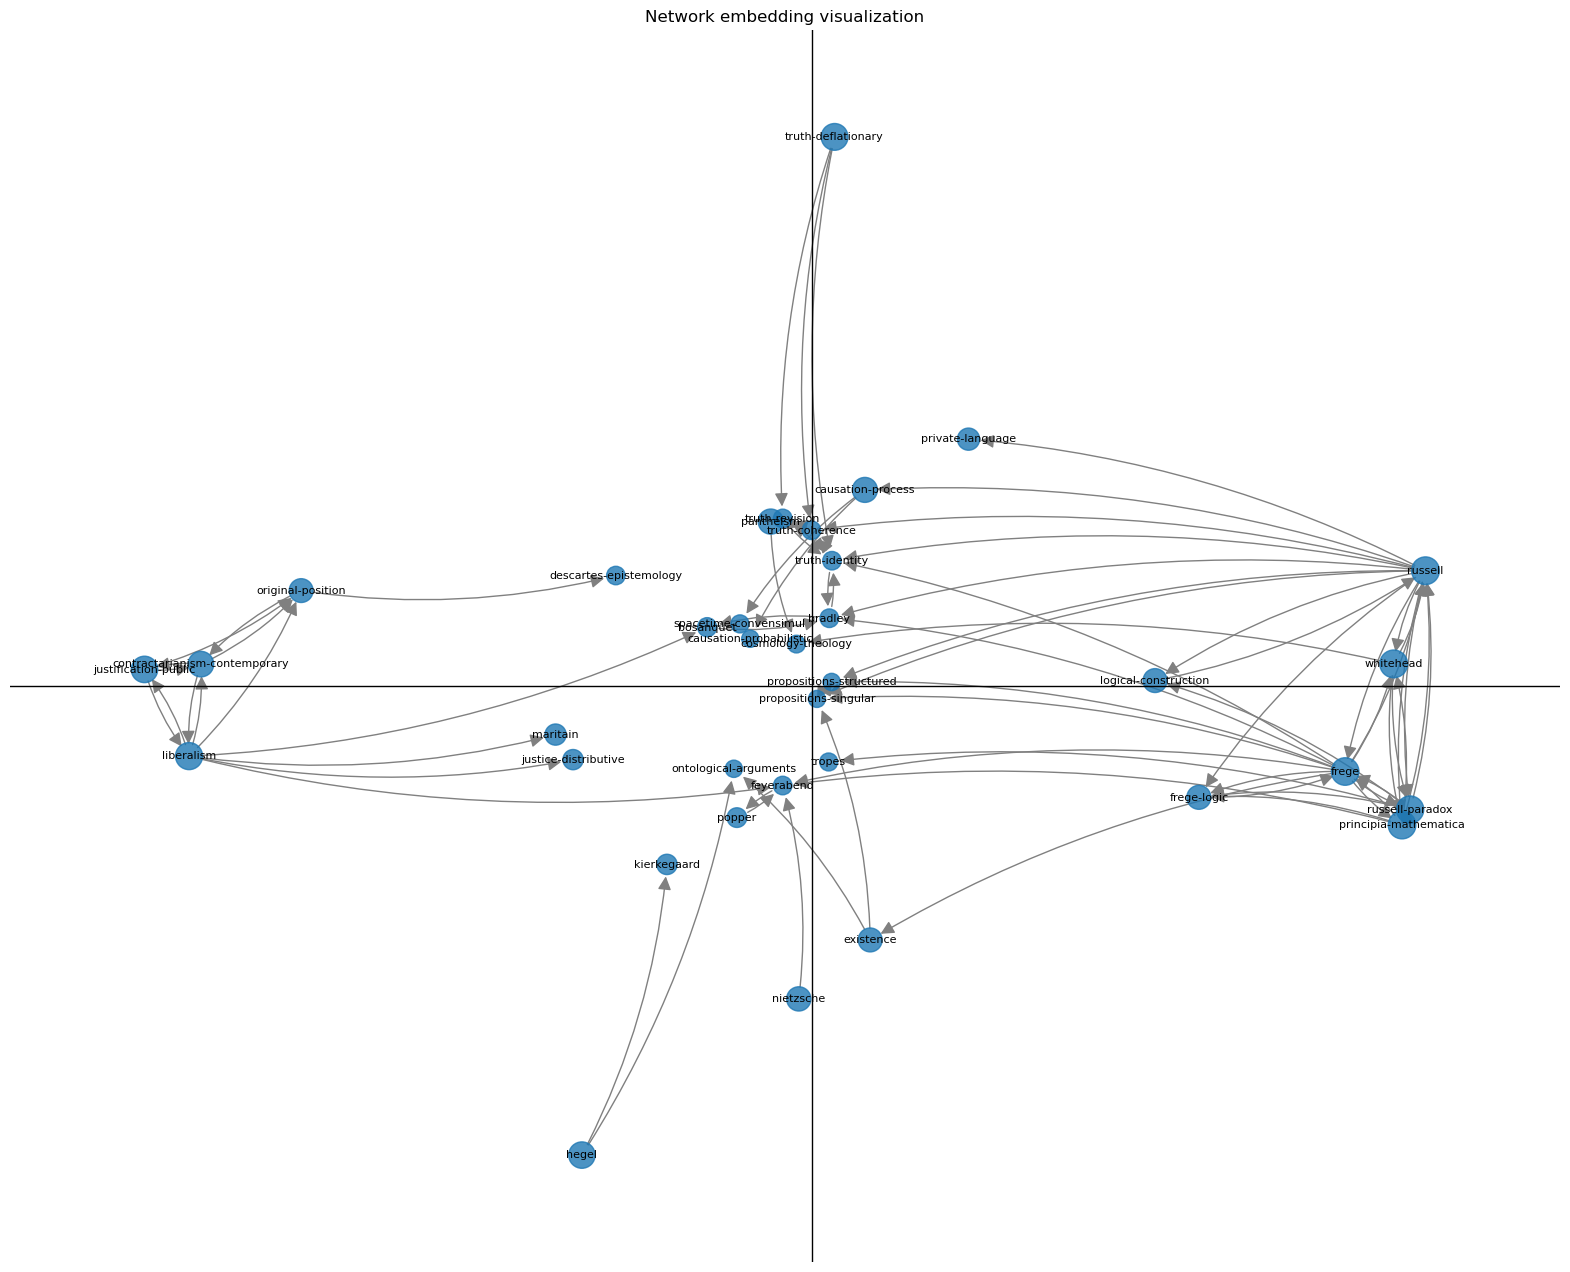

In [19]:
simple_model.visualize(node_labels=node_list)

In [4]:
parakeets = pd.read_csv("data/aggXquarter.txt", sep="\t", header=0)
parakeets.head()

,group,study.quarter,actor,target,number.wins
0,G1,1,bbb,rgn,1
1,G1,1,bgn,bng,2
2,G1,1,bgn,ggg,4
3,G1,1,bgn,grr,1
4,G1,1,bgn,nrb,3


In [ ]:
def get_parakeet_data(group="g1"):

    df = pd.read_csv("data/aggXquarter.txt", sep="\t", header=0)
    df = df[df["group"] == group.upper()]

    G = nx.MultiDiGraph()
    for _, row in df.iterrows():
        G.add_edge(row['actor'], row['target'])

    components = list(nx.weakly_connected_components(G))
    largest_wcc = max(components, key=len)
    G_wcc = G.subgraph(largest_wcc).copy()

    return G_wcc

In [25]:
G_parakeet_g1 = get_parakeet_data("g1")
A_parakeet_g1 = nx.to_numpy_array(G_parakeet_g1, nodelist=G_parakeet_g1.nodes)

### Learn multigraph model with $k=5$

100%|██████████| 500/500 [00:56<00:00,  8.92it/s]


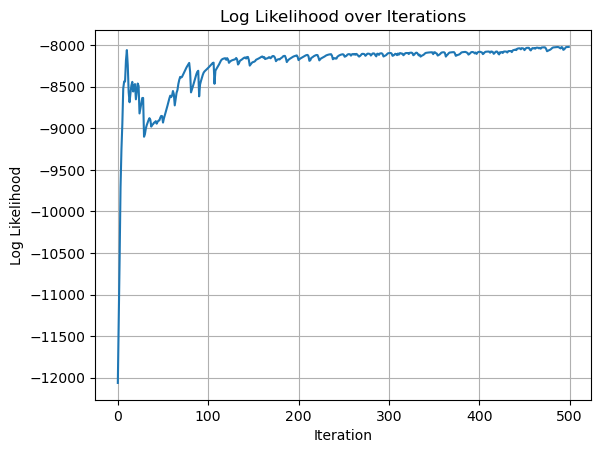

In [38]:
g1_model = SequentialHierarchyCommunityMulti(adj_matrix=A_parakeet_g1, embedding_dim=4, k=5, beta=1)
_ = g1_model.fit(max_iter=500)

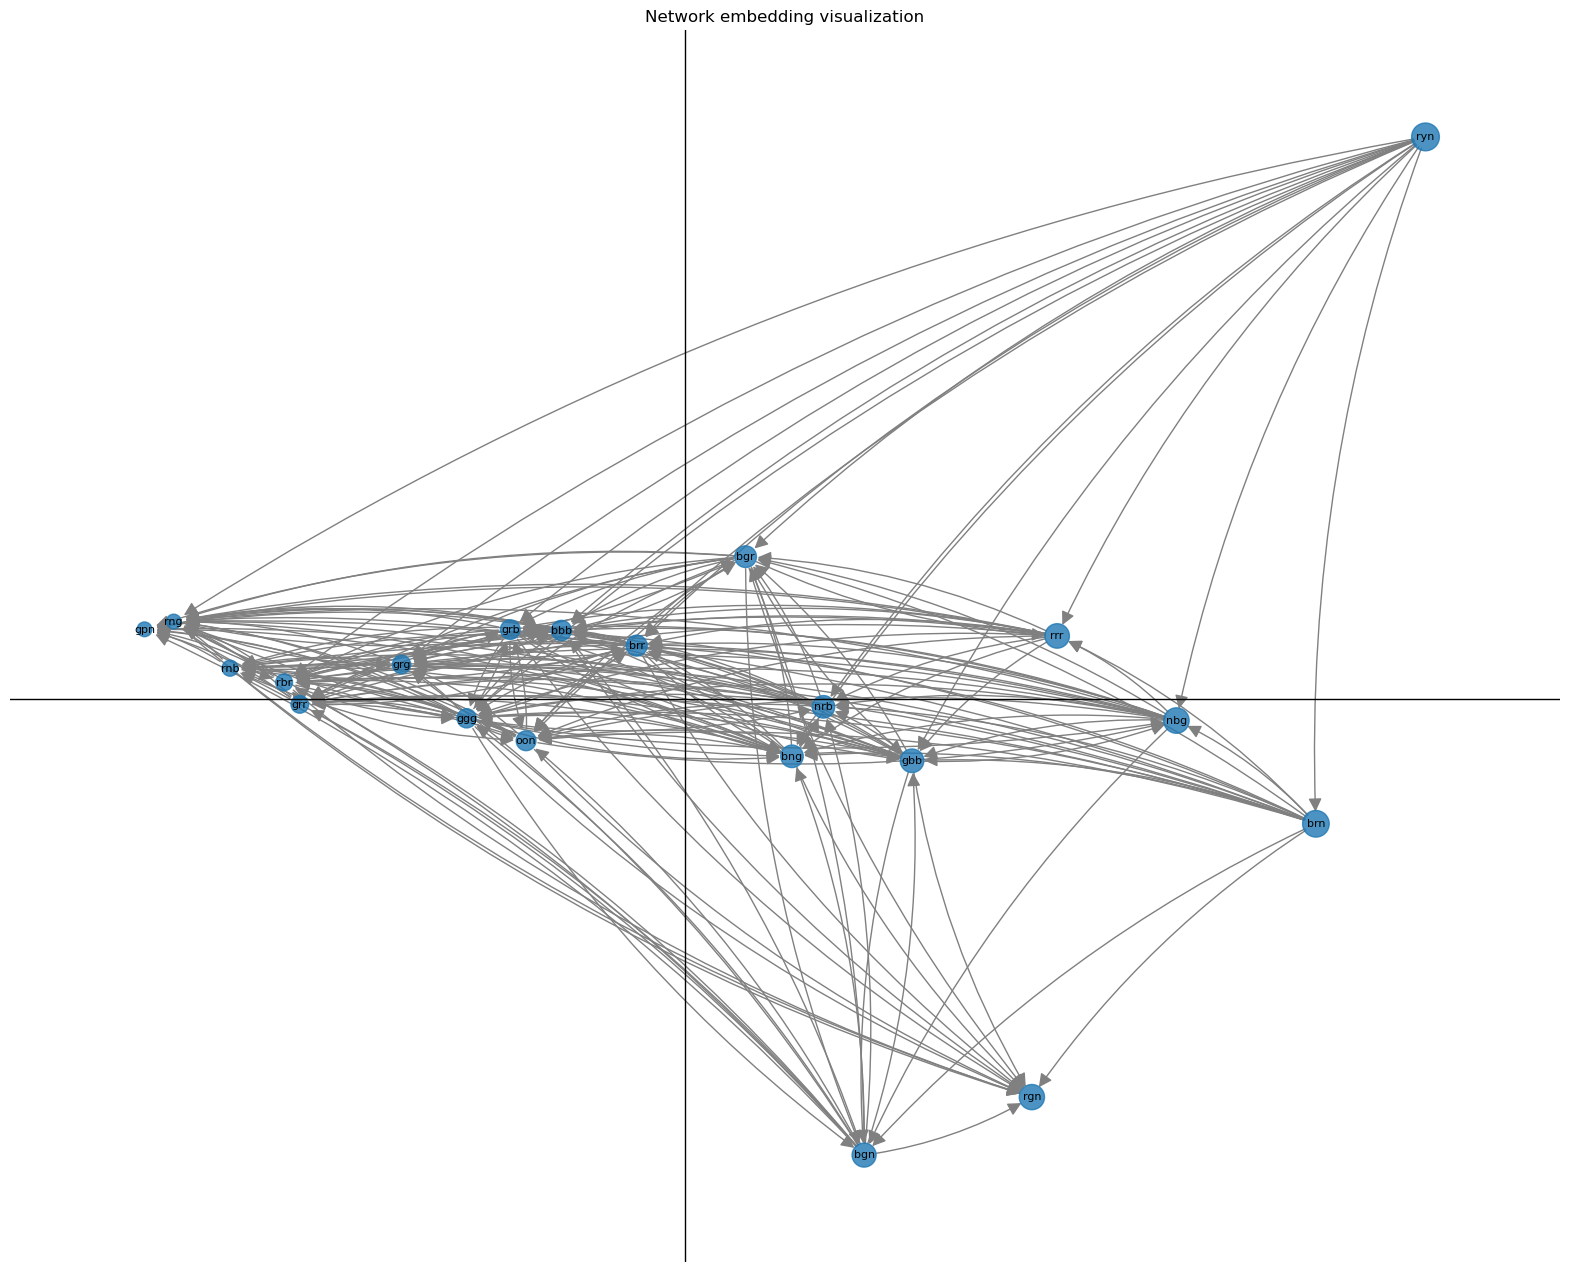

In [40]:
g1_model.visualize(node_labels=list(G_parakeet_g1.nodes))

#### Compare to original network net out degree and SR ranks

In [105]:
t = (A_parakeet_g1 + 1e-8) / (A_parakeet_g1.sum(axis=1) + 1e-8)
eigenvalues, eigenvectors = np.linalg.eig(t)
idx = np.argmax(eigenvalues)

# Get the corresponding eigenvector
largest_eigenvector = eigenvectors[:, idx].real
largest_eigenvalue = eigenvalues[idx].real
print(f"Largest eigenvalue: {largest_eigenvalue}")
print(f"Corresponding eigenvector: {largest_eigenvector}")

Largest eigenvalue: 3.098715613083828
Corresponding eigenvector: [-1.65069284e-01 -1.62972421e-09 -1.82645285e-01 -2.25162091e-01
 -2.85428918e-01 -8.10213348e-02 -1.01978097e-01 -3.16620752e-01
 -3.14030768e-01 -1.75981643e-01 -3.42519224e-01 -4.63599256e-02
 -2.46970422e-01 -2.20153499e-01 -4.17598483e-01 -1.32698725e-01
 -1.29103153e-01 -1.59293934e-01 -1.62972421e-09 -3.01192074e-01
 -8.21020093e-02]


In [100]:
G_weighted = nx.DiGraph()
for u, v, data in G_parakeet_g1.edges(data=True):
    if G_weighted.has_edge(u, v):
        G_weighted[u][v]["weight"] += 1
    else:
        G_weighted.add_edge(u, v, **{"weight": 1})
ec = nx.eigenvector_centrality(G_weighted, max_iter=1000, weight="weight")

/Users/larremoreadmin/miniconda3/envs/networks/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


[]

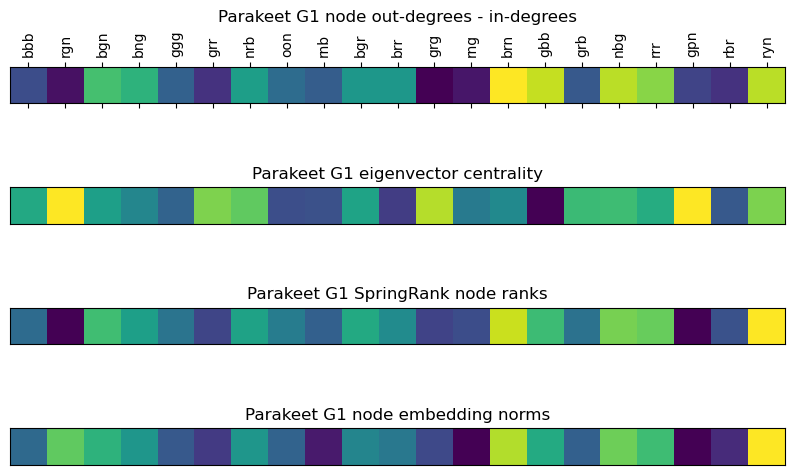

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(10, 6))

sr_model = SpringRank()
sr_model.fit(A_parakeet_g1)

ax[0].matshow([A_parakeet_g1.sum(axis=1) - A_parakeet_g1.sum(axis=0)])
ax[0].set_title("Parakeet G1 node out-degrees - in-degrees")
ax[0].set_xticks(range(len(G_parakeet_g1.nodes)), G_parakeet_g1.nodes, rotation=90)
ax[0].set_yticks([])

ax[1].matshow([np.array(largest_eigenvector)])
ax[1].set_title("Parakeet G1 eigenvector centrality")
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[2].matshow([sr_model.ranks])
ax[2].set_title("Parakeet G1 SpringRank node ranks")
ax[2].set_yticks([])
ax[2].set_xticks([])

ax[3].matshow([np.linalg.norm(g1_model.embeddings, axis=1)])
ax[3].set_title("Parakeet G1 node embedding norms")
ax[3].set_yticks([])
ax[3].set_xticks([])

### Learn multigraph model with $k=1$

The fit looks a lot better than with $k=5$! The Poisson density already has an $\exp{(-cd_{{ij}})}$ term, so raising $d_{ij}$ to a power is unnecessary.

100%|██████████| 500/500 [00:56<00:00,  8.89it/s]


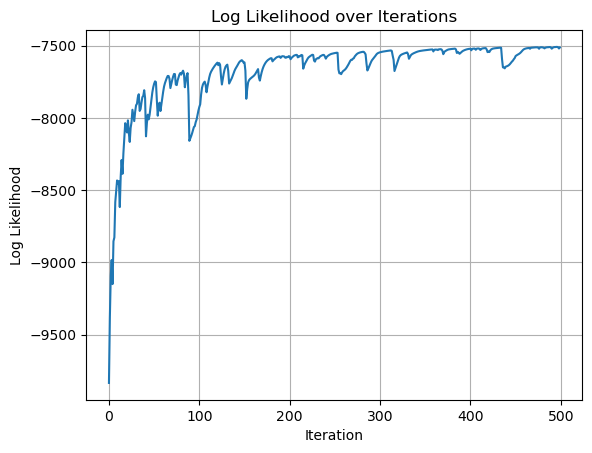

In [108]:
g1_model_k1 = SequentialHierarchyCommunityMulti(adj_matrix=A_parakeet_g1, embedding_dim=4, k=1, beta=1)
_ = g1_model_k1.fit(max_iter=500)

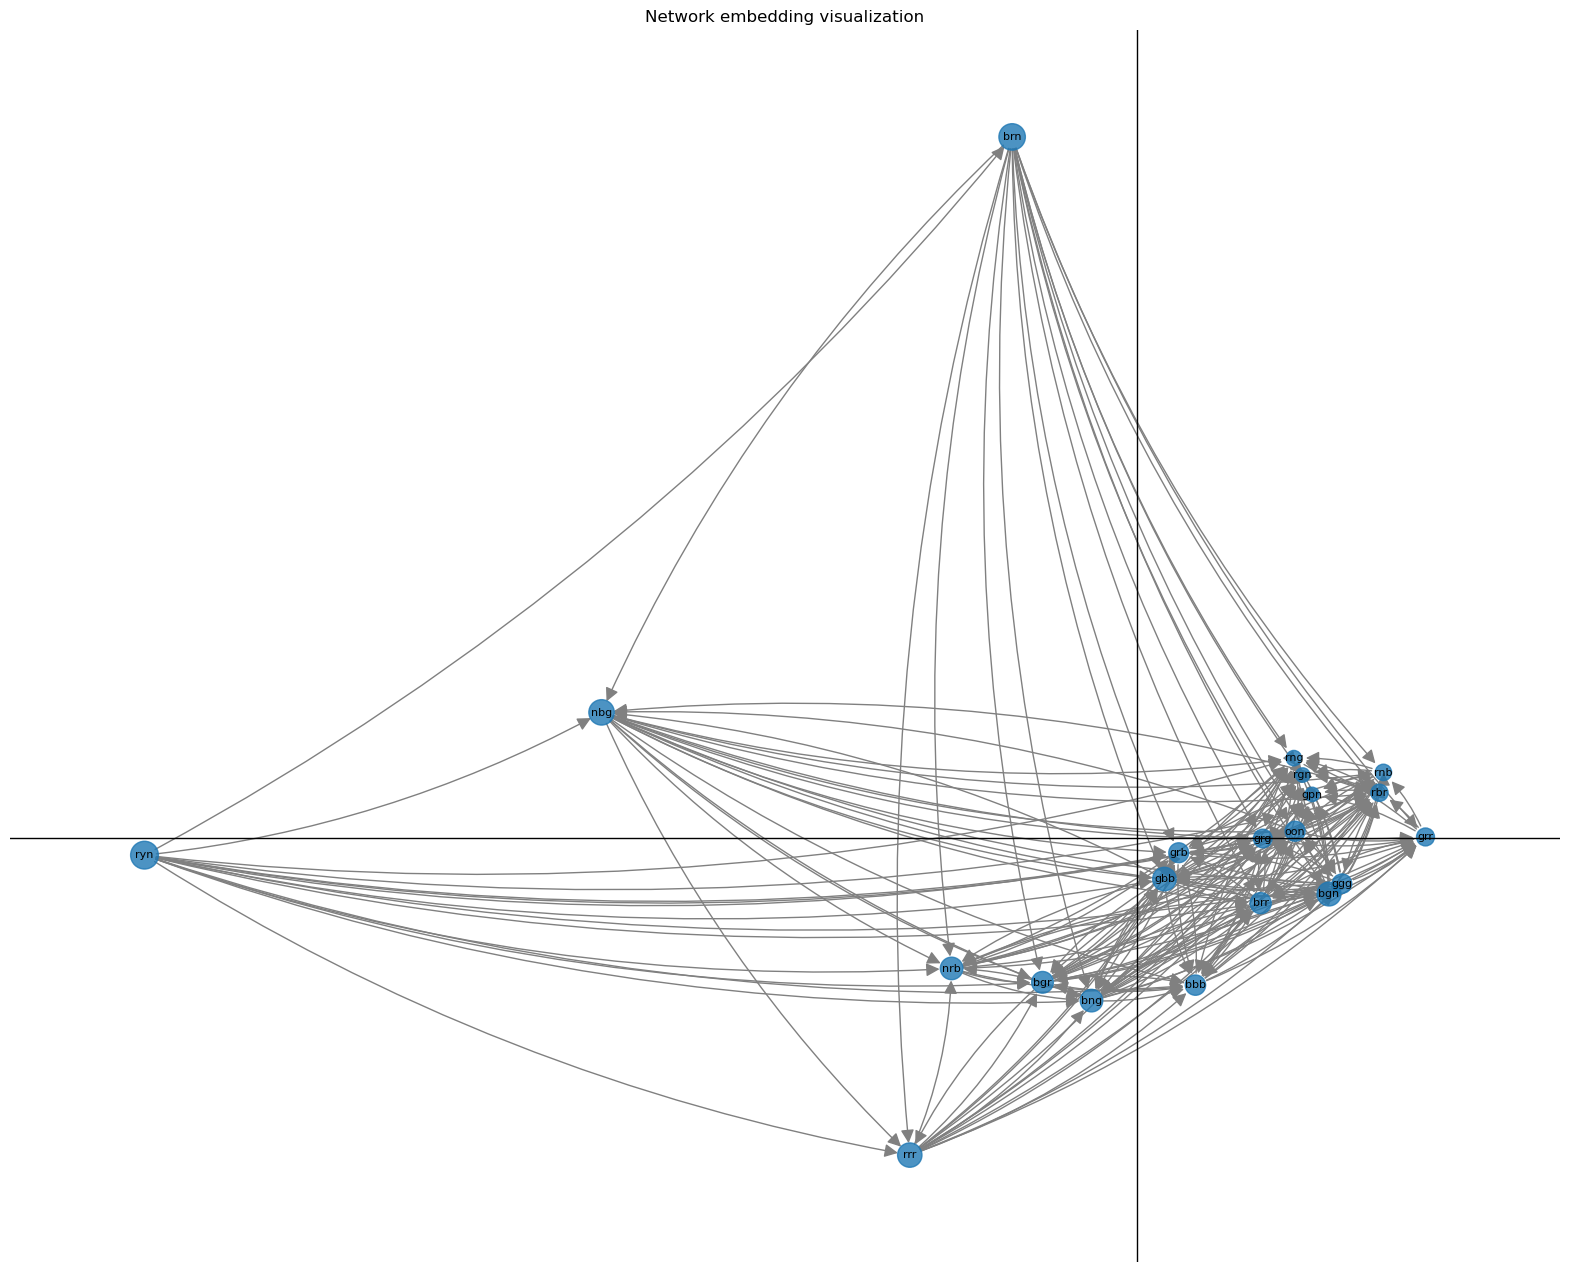

In [109]:
g1_model_k1.visualize(node_labels=list(G_parakeet_g1.nodes))

/Users/larremoreadmin/miniconda3/envs/networks/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


[]

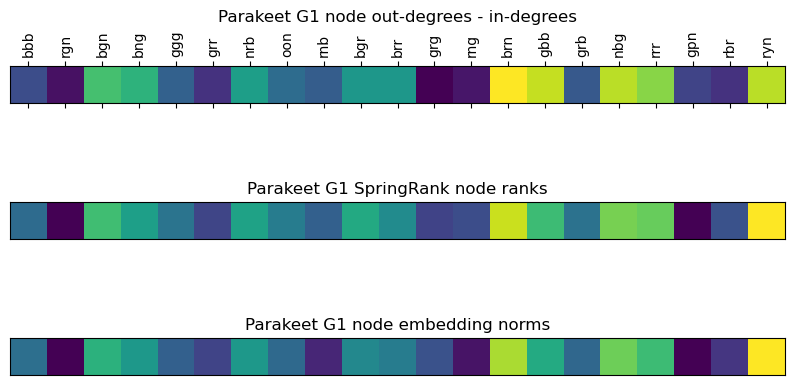

In [110]:
fig, ax = plt.subplots(3, 1, figsize=(10, 5))

sr_model = SpringRank()
sr_model.fit(A_parakeet_g1)

ax[0].matshow([A_parakeet_g1.sum(axis=1) - A_parakeet_g1.sum(axis=0)])
ax[0].set_title("Parakeet G1 node out-degrees - in-degrees")
ax[0].set_xticks(range(len(G_parakeet_g1.nodes)), G_parakeet_g1.nodes, rotation=90)
ax[0].set_yticks([])

ax[1].matshow([sr_model.ranks])
ax[1].set_title("Parakeet G1 SpringRank node ranks")
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[2].matshow([np.linalg.norm(g1_model_k1.embeddings, axis=1)])
ax[2].set_title("Parakeet G1 node embedding norms")
ax[2].set_yticks([])
ax[2].set_xticks([])

# Model -> Data -> Model' Loop

In [73]:
# generate a synthetic parakeet G1 network
m = A_parakeet_g1.sum()
A_gen = g1_model.generate(expected_num_edges=m)
print(A_gen.sum())

456.0


Text(0.5, 1.0, 'Original Parakeet G1 network')

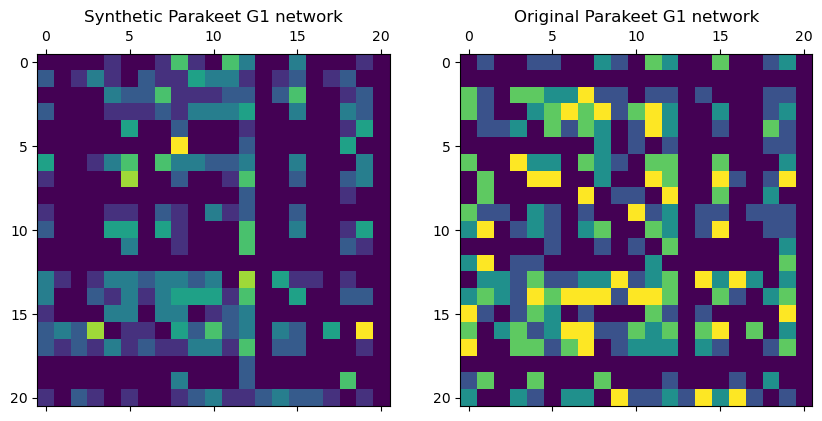

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].matshow(A_gen)
ax[0].set_title("Synthetic Parakeet G1 network")
ax[1].matshow(A_parakeet_g1)
ax[1].set_title("Original Parakeet G1 network")

100%|██████████| 500/500 [00:55<00:00,  8.93it/s]


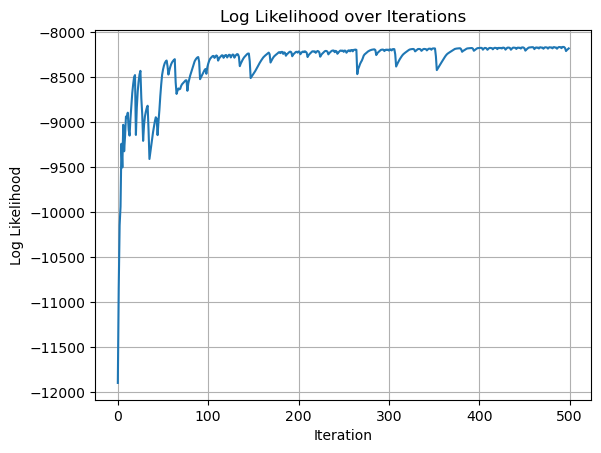

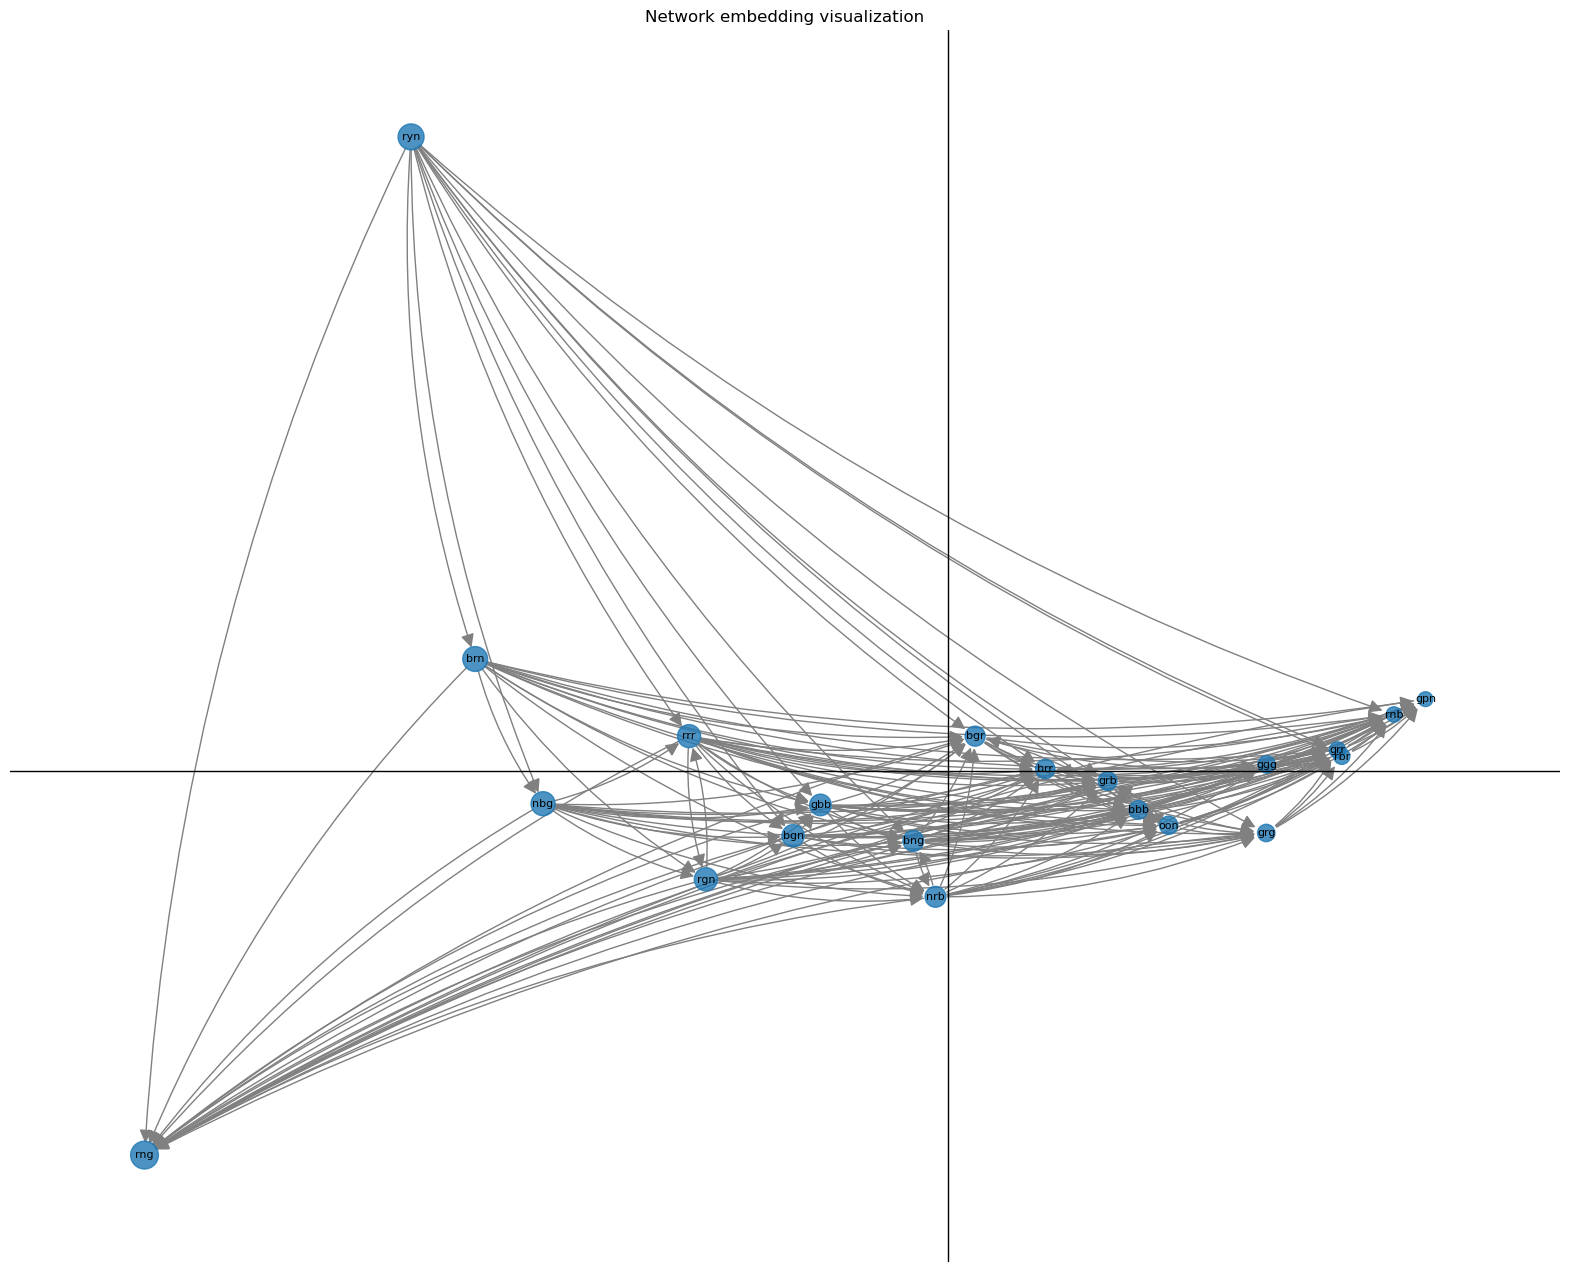

In [78]:
# fit a new model to the synthetic network
g1_model_gen = SequentialHierarchyCommunityMulti(adj_matrix=A_gen, embedding_dim=4, k=5, beta=1)
_ = g1_model_gen.fit(max_iter=500)
g1_model_gen.visualize(node_labels=list(G_parakeet_g1.nodes))

In [84]:
# compare the cosine distances between embeddings in original and synthetic fit models
d_orig = utils.scaled_cosine_sim(g1_model.embeddings)
d_synth = utils.scaled_cosine_sim(g1_model_gen.embeddings)
rho, _ = stats.spearmanr(d_orig.ravel(), d_synth.ravel())
tau, _ = stats.kendalltau(d_orig.ravel(), d_synth.ravel())
jsd = spatial.distance.jensenshannon(d_orig.ravel(), d_synth.ravel())
wd = stats.wasserstein_distance_nd(d_orig, d_synth)
print(f"Spearman correlation: {rho:.4f}")
print(f"Kendall tau correlation: {tau:.4f}")
print(f"Jensen-Shannon divergence: {jsd:.4f}")
print(f"Wasserstein distance: {wd:.4f}")

Spearman correlation: 0.5873
Kendall tau correlation: 0.4272
Jensen-Shannon divergence: 0.0205
Wasserstein distance: 0.2027
